# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Data Exploration & Visualization

In [2]:
def plot_sample_images(dataset_path, categories, num_samples=5):
    fig, axes = plt.subplots(len(categories), num_samples, figsize=(10, 8))
    for i, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        images = os.listdir(category_path)[:num_samples]
        for j, img_name in enumerate(images):
            img = cv2.imread(os.path.join(category_path, img_name), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (128, 128))
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
        axes[i, 0].set_ylabel(category, fontsize=12)
    plt.show()

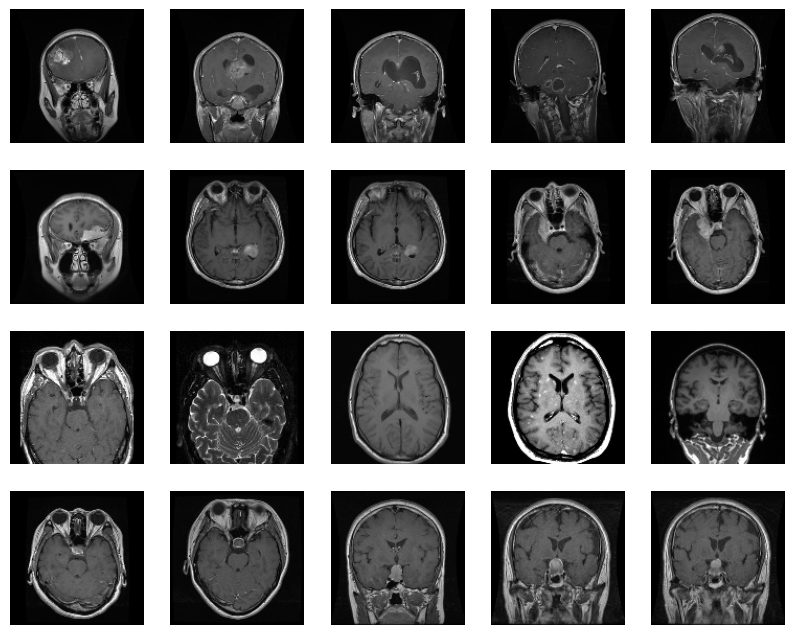

In [3]:
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
plot_sample_images('Dataset/Training', categories)
 

# Pixel Intensity Histogram

In [4]:
def plot_pixel_intensity(dataset_path, category):
    category_path = os.path.join(dataset_path, category)
    images = os.listdir(category_path)[:50]
    pixel_values = []
    for img_name in images:
        img = cv2.imread(os.path.join(category_path, img_name), cv2.IMREAD_GRAYSCALE)
        pixel_values.extend(img.flatten())
    
    plt.figure(figsize=(8, 5))
    sns.histplot(pixel_values, bins=50, kde=True, color='blue')
    plt.title(f'Pixel Intensity Distribution - {category}')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

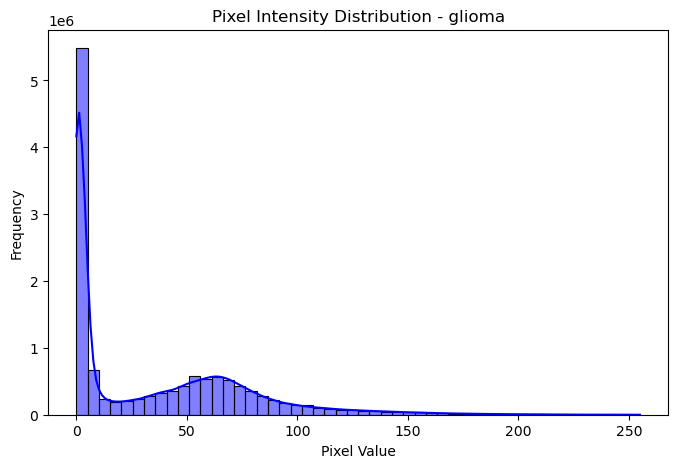

In [5]:
plot_pixel_intensity('Dataset/Training', 'glioma')

# Data Preprocessing & Augmentation

In [6]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 8

In [7]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

In [8]:
train_generator = datagen.flow_from_directory(
    'Dataset/Training',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

Found 4571 images belonging to 4 classes.


In [9]:
val_generator = datagen.flow_from_directory(
    'Dataset/Training',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 1141 images belonging to 4 classes.


In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'Dataset/Testing',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 1311 images belonging to 4 classes.


# CNN Model Definition

In [11]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

C:\Users\RAHULSRI\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


# Compile Model

In [12]:
model.compile(optimizer=AdamW(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model Training

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('brain_tumor_model.keras', save_best_only=True)

In [18]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 104s 181ms/step - accuracy: 0.7366 - loss: 0.6641 - val_accuracy: 0.6354 - val_loss: 0.8589
Epoch 2/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 101s 175ms/step - accuracy: 0.7647 - loss: 0.5941 - val_accuracy: 0.7362 - val_loss: 0.7617
Epoch 3/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 99s 172ms/step - accuracy: 0.7759 - loss: 0.5352 - val_accuracy: 0.7485 - val_loss: 0.6276
Epoch 4/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 97s 169ms/step - accuracy: 0.8002 - loss: 0.4951 - val_accuracy: 0.7248 - val_loss: 0.8421
Epoch 5/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 100s 174ms/step - accuracy: 0.8238 - loss: 0.4218 - val_accuracy: 0.7713 - val_loss: 0.6081
Epoch 6/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 102s 176ms/step - accuracy: 0.8254 - loss: 0.4378 - val_accuracy: 0.7765 - val_loss: 0.6310
Epoch 7/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 100s 174ms/step - accuracy: 0.8444 - loss: 0.3910 - val_accuracy: 0.7756 - val_loss: 0.5845
Epoch 8/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 98s 171ms/step - accuracy: 0.8575 - lo

# Model Evaluation

In [19]:
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

164/164 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step


In [20]:
print(classification_report(y_true, y_pred, target_names=categories))

              precision    recall  f1-score   support

      glioma       0.24      0.17      0.20       300
  meningioma       0.24      0.21      0.22       306
     notumor       0.30      0.39      0.34       405
   pituitary       0.26      0.26      0.26       300

    accuracy                           0.27      1311
   macro avg       0.26      0.26      0.25      1311
weighted avg       0.26      0.27      0.26      1311



# Confusion Matrix

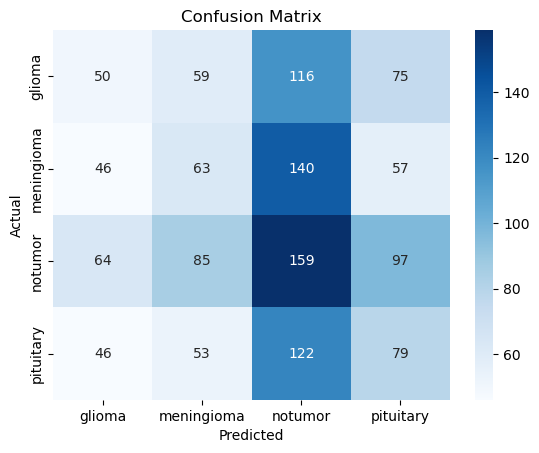

In [21]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Model Testing

In [22]:
sample_image_path = 'Dataset/Testing/glioma/Te-gl_0050.jpg'
img = cv2.imread(sample_image_path)
img = cv2.resize(img, IMG_SIZE)
img = img / 255.0
img = np.expand_dims(img, axis=0)
prediction = model.predict(img)
predicted_class = categories[np.argmax(prediction)]
print(f'Predicted Class: {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
Predicted Class: glioma


# Model Training History

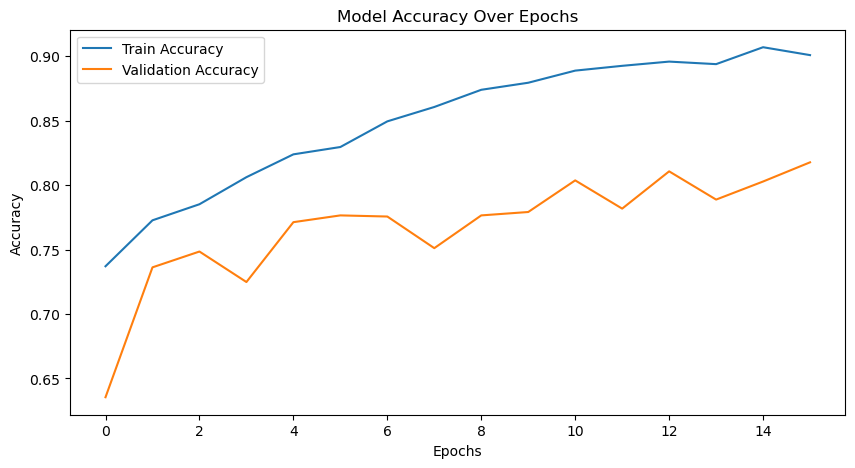

In [23]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy Over Epochs')
plt.show()


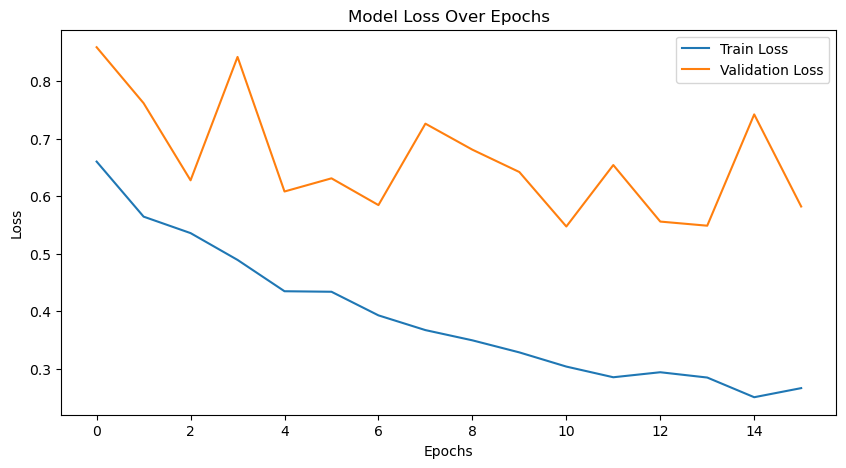

In [24]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Over Epochs')
plt.show()